In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import string
from tqdm import tqdm
from multiprocessing import Pool
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
# roc_auc_score, roc_curve, precision_score, recall_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings 
warnings.filterwarnings('ignore')

# Importing the Pre-processed_Tweet.csv file which i saved in the bags of word model (so that not to pre-process the tweet again)

In [2]:
# Now you can read the CSV file
df = pd.read_csv('Pre-processed_Tweets.csv')

In [3]:
df.head()

,text,sentiment,word_count,char_count,stemmed_content
0,Sooo SAD I will miss you here in San Diego!!!,0,11,46,sooo sad miss san diego
1,my boss is bullying me...,0,5,25,boss bulli
2,what interview! leave me alone,0,6,31,interview leav alon
3,"Sons of ****, why couldn`t they put them on t...",0,15,75,son put releas alreadi bought
4,2am feedings for the baby are fun when he is a...,1,14,64,feed babi fun smile coo


In [4]:
#Let's drop selected text & text id column
df.drop(['word_count', 'text','char_count'], axis=1, inplace=True)
df.head()

,sentiment,stemmed_content
0,0,sooo sad miss san diego
1,0,boss bulli
2,0,interview leav alon
3,0,son put releas alreadi bought
4,1,feed babi fun smile coo


In [5]:
# Again checking class distribution of target column
df['sentiment'].value_counts()

sentiment
1    8582
0    7781
Name: count, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16363 entries, 0 to 16362
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        16363 non-null  int64 
 1   stemmed_content  16358 non-null  object
dtypes: int64(1), object(1)
memory usage: 255.8+ KB


In [7]:
#Descriptive summary of dataset
df.describe()

,sentiment
count,16363.000000
mean,0.524476
std,0.499416
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
#Let's check Null values
df.isnull().sum()
#Dropping the null values
df.dropna(inplace=True)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16358 entries, 0 to 16362
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        16358 non-null  int64 
 1   stemmed_content  16358 non-null  object
dtypes: int64(1), object(1)
memory usage: 383.4+ KB


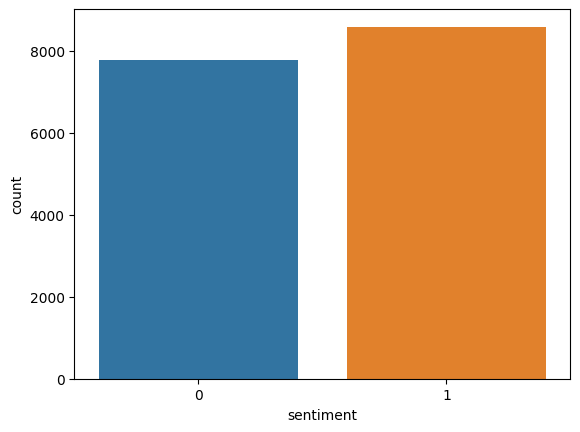

In [10]:
sns.countplot(x=df['sentiment'])
plt.show()

In [11]:
nltk.download('stopwords')  
#Import the english stop words list from NLTK
stopwords_english = stopwords.words('english')
print('Stop words\n')
print(stopwords_english)
print('\nPunctuation\n')
print(string.punctuation)

Stop words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASHWANI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


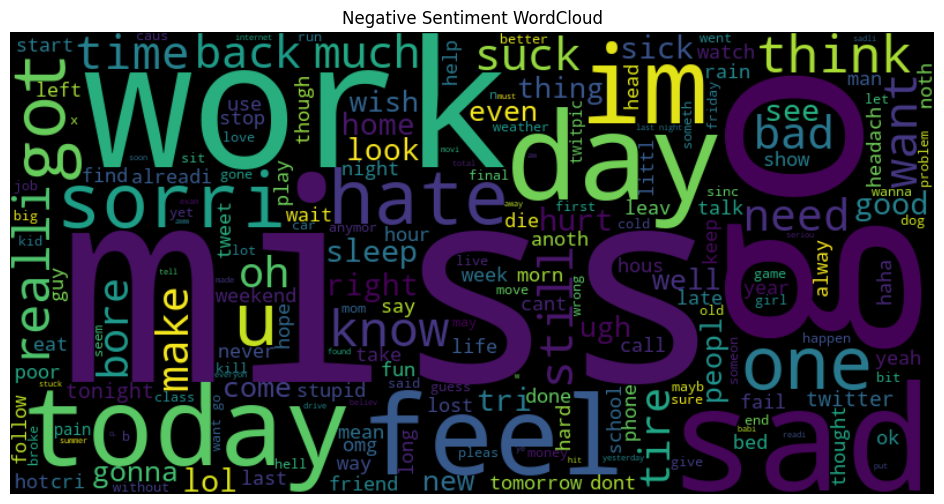

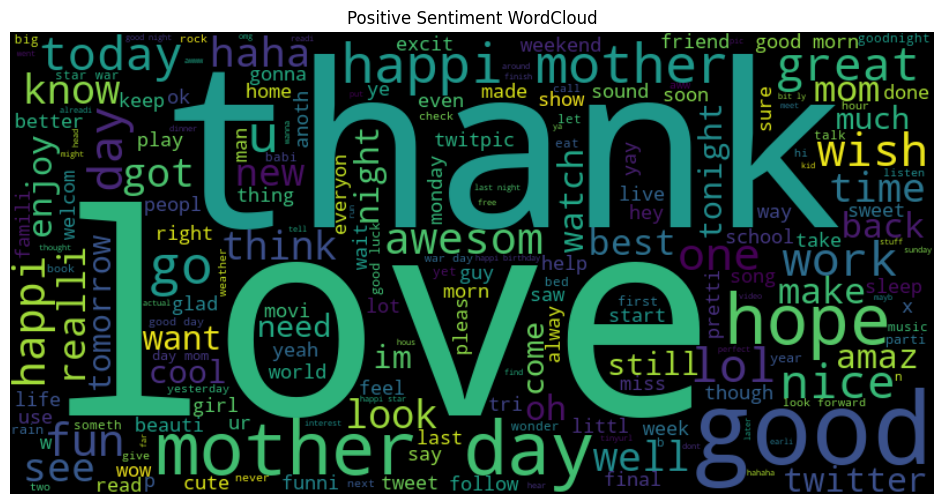

In [12]:
from wordcloud import WordCloud, STOPWORDS
negative_df = df[df['sentiment'] == 0]
positive_df = df[df['sentiment'] == 1]
# neutral_df = df[df['sentiment'] == 'neutral']

# Define a function to generate and display a WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['stemmed_content'])
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT' ])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='black', 
                          width=800, height=400).generate(cleaned_word)
    plt.figure(figsize=(15, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()
# Generate and display WordClouds for each sentiment category
generate_wordcloud(negative_df, 'Negative Sentiment WordCloud')
generate_wordcloud(positive_df, 'Positive Sentiment WordCloud')
# generate_wordcloud(neutral_df, 'Neutral Sentiment WordCloud')

# Making the frequency table

In [13]:
# # Step 1: Create a list of all unique words by tokenizing it 
# all_words = ' '.join(df['stemmed_content']).split()
# unique_words = set(all_words)

# # Step 2: Create an empty DataFrame to store word frequencies
# word_frequency = pd.DataFrame(columns=['unique_word', 'positive_frequency', 'negative_frequency'])

# # Step 3: Count word frequencies for positive (target=1) and negative (target=0) labeled tweets
# for word in unique_words:
#     positive_count = sum((df['sentiment'] == 1) & (df['stemmed_content'].str.contains(word)))
#     negative_count = sum((df['sentiment'] == 0) & (df['stemmed_content'].str.contains(word)))
    
#     word_frequency = pd.concat([word_frequency, pd.DataFrame({'unique_word': [word], 'positive_frequency': [positive_count], 'negative_frequency': [negative_count]})])

# # Display the resulting DataFrame
# print(word_frequency.head())

# Run only one time(which is already done), need not to run again

In [14]:
# word_frequency.to_csv('Frequency_Table.csv', index=False)

In [15]:
word_frequency = pd.read_csv('Frequency_Table.csv')

In [16]:
# Taking 2000 dataset from the original one 
negative_sentiment = df[df['sentiment'] == 0].head(1000)
positive_sentiment = df[df['sentiment'] == 1].head(1000)

# Concatenate the balanced dataframes
balanced_data = pd.concat([negative_sentiment, positive_sentiment])

# Shuffle the balanced data
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (X) and target (y)
X = balanced_data['stemmed_content']
y = balanced_data['sentiment']

In [17]:
from sklearn.model_selection import train_test_split
# Splitting the dataset into training and testing sets, maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# Print the shapes of the training and testing sets
print("Training set shape: X_train={}, y_train={}".format(X_train.shape, y_train.shape))
print("Testing set shape: X_test={}, y_test={}".format(X_test.shape, y_test.shape))

Training set shape: X_train=(1600,), y_train=(1600,)
Testing set shape: X_test=(400,), y_test=(400,)


# Making 3-featured array from each tweet of X_train and X_test

In [18]:
def calculate_features(tweet, word_frequency_df):
    # Tokenize the tweet into words and lowercase them
    words = tweet.lower().split()

    # Initialize feature values
    bias_term = 1  
    sum_positive_freq = 0
    sum_negative_freq = 0
    
    # Iterate over each unique word in the tweet
    for word in set(words):
        # Check if the word exists in the word_frequency_df
        word_row = word_frequency_df[word_frequency_df['unique_word'].str.lower() == word]
        if not word_row.empty:
            # Add positive and negative frequencies if the word is found
            sum_positive_freq += word_row['positive_frequency'].values[0]
            sum_negative_freq += word_row['negative_frequency'].values[0]

    return [bias_term, sum_positive_freq, sum_negative_freq]


# Apply the function to X_train to create the feature arrays
X_train_features = [calculate_features(tweet, word_frequency) for tweet in X_train]

# Convert the feature arrays to a NumPy array for easier handling
X_train_features = pd.DataFrame(X_train_features, columns=['Bias_term','Sum Positive Frequency', 'Sum Negative Frequency'])


# Apply the function to X_test to create the feature arrays
X_test_features = [calculate_features(tweet, word_frequency) for tweet in X_test]

# Convert the feature arrays to a NumPy array for easier handling
X_test_features = pd.DataFrame(X_test_features, columns=['Bias_term','Sum Positive Frequency', 'Sum Negative Frequency'])

print("Train Dataframe")
# Display the resulting DataFrame
print(X_train_features.head())

print("Test Dataframe")
# Display the resulting DataFrame
print(X_test_features.head())


Train Dataframe
   Bias_term  Sum Positive Frequency  Sum Negative Frequency
0          1                     331                     704
1          1                    1039                     860
2          1                    2909                    2127
3          1                    1481                     584
4          1                    3508                    2022
Test Dataframe
   Bias_term  Sum Positive Frequency  Sum Negative Frequency
0          1                      26                     319
1          1                    2150                    1209
2          1                    2233                    2571
3          1                     301                     313
4          1                    1541                    1135


In [19]:
# Converting Train and test dataframe into 2D numpy array
X_train_array = X_train_features.values
X_test_array = X_test_features.values

In [20]:
# Print the training and testing 2D Array
print("Training-Array")
print(X_train_array)

print("Testing-Array")
print(X_test_array)

Training-Array
[[   1  331  704]
 [   1 1039  860]
 [   1 2909 2127]
 ...
 [   1  778  485]
 [   1 2355 2504]
 [   1 2874 1201]]
Testing-Array
[[   1   26  319]
 [   1 2150 1209]
 [   1 2233 2571]
 ...
 [   1  495  581]
 [   1  803 1586]
 [   1 2169 1286]]


# Perform Normalization of X_train_array and x_test_array 

In [21]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform X_train_array
X_train_normalized = scaler.fit_transform(X_train_array)

# Transform X_test_array (using the same scaler)
X_test_normalized = scaler.transform(X_test_array)

# Print normalized arrays
print("Normalized Training-Array")
print(X_train_normalized)

print("Normalized Testing-Array")
print(X_test_normalized)


Normalized Training-Array
[[0.         0.01204425 0.02872883]
 [0.         0.03780656 0.03509488]
 [0.         0.1058511  0.08679861]
 ...
 [0.         0.02830944 0.01979188]
 [0.         0.08569245 0.10218323]
 [0.         0.10457754 0.04901041]]
Normalized Testing-Array
[[0.         0.00094607 0.01301775]
 [0.         0.07823303 0.04933687]
 [0.         0.08125318 0.10491736]
 ...
 [0.         0.01801179 0.02370945]
 [0.         0.02921913 0.06472149]
 [0.         0.07892439 0.05247909]]


# Model building (passing X_train_normalized and y_train into logistic regression)

Iteration    0: Cost 0.6931471805599452
Iteration 100000: Cost 0.573994974636681
Iteration 200000: Cost 0.5420133063728038
Stopping early at iteration 282658: Cost not decreasing significantly


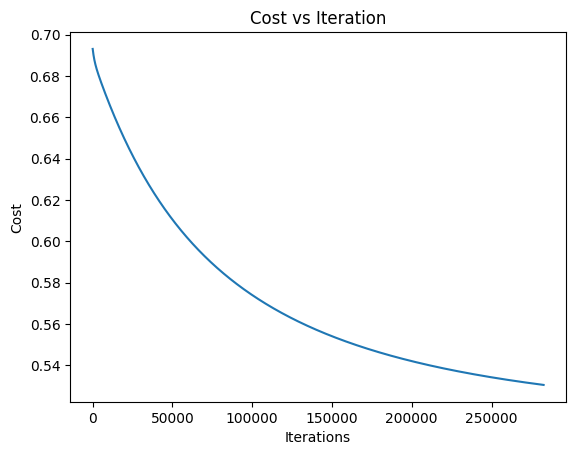

Accuracy: 77.8125


In [22]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegressionBinary:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.theta = None
        self.cost_history = []

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Convert input data to NumPy arrays
        X = np.array(X)
        y = np.array(y)

        # Verify X and y dimensions
        if len(X.shape) != 2 or len(y.shape) != 1:
            raise ValueError("Input data must be 2D array for features and 1D array for target")

        m, n = X.shape  # Number of samples and features
        self.theta = np.zeros(n)

        for i in range(self.n_iterations):
            z = np.dot(X, self.theta)
            h = self.sigmoid(z)
            error = h - y
            gradient = np.dot(X.T, error) / m
            self.theta -= self.learning_rate * gradient

            # Compute and store cost
            cost = self._compute_cost(h, y)
            self.cost_history.append(cost)

            # Print cost after every 100 iterations
            if i % math.ceil(self.n_iterations / 10) == 0:
                print(f"Iteration {i:4d}: Cost {cost}")
        
            # Early stopping if cost is not decreasing or becomes negative
            if i > 0 and self.cost_history[-2] - self.cost_history[-1] < 1e-7:
                print(f"Stopping early at iteration {i}: Cost not decreasing significantly")
                break

    def _compute_cost(self, h, y):
        m = len(y)
        cost = (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost

    def predict(self, X):
        z = np.dot(X, self.theta)
        h = self.sigmoid(z)
        return (h >= 0.5).astype(int)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y) * 100
        
    def plot_cost_history(self):
        plt.plot(range(len(self.cost_history)), self.cost_history)
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.title('Cost vs Iteration')
        plt.show()

# Initialize and fit the logistic regression model
logistic_model = LogisticRegressionBinary(learning_rate=0.1, n_iterations=1000000)
logistic_model.fit(X_train_normalized, y_train)
# Plot cost history
logistic_model.plot_cost_history()
# Calculate accuracy
accuracy = logistic_model.accuracy(X_train_normalized, y_train)
print("Accuracy:", accuracy)


In [23]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to make predictions
def predict(X, theta):
    z = np.dot(X, theta)
    h = 1 / (1 + np.exp(-z))
    return (h >= 0.5).astype(int)

# Make predictions on training data
y_train_pred = predict(X_train_normalized, logistic_model.theta)

# Print metrics for training data
print("Result on Training Data:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred) * 100}")
print(f"Precision: {precision_score(y_train, y_train_pred)}")
print(f"Recall: {recall_score(y_train, y_train_pred)}")
print(f"F1 Score: {f1_score(y_train, y_train_pred)}")

# Make predictions on test data
y_test_pred = predict(X_test_normalized, logistic_model.theta)

# Print metrics for test data
print("\n Result on Test Data:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred) * 100}")
print(f"Precision: {precision_score(y_test, y_test_pred)}")
print(f"Recall: {recall_score(y_test, y_test_pred)}")
print(f"F1 Score: {f1_score(y_test, y_test_pred)}")


Result on Training Data:
Accuracy: 77.8125
Precision: 0.7560414269275029
Recall: 0.82125
F1 Score: 0.7872977831036548

 Result on Test Data:
Accuracy: 79.75
Precision: 0.784688995215311
Recall: 0.82
F1 Score: 0.8019559902200489
